## 初めてのベイズ推論実習

In [2]:
%matplotlib inline
!pip3 install japanize-matplotlib | tail -n 1
!pip3 install seaborn | tail -n 1
!pip3 install scipy | tail -n 1
!pip3 install pymc | tail -n 1
!pip3 install arviz | tail -n 1
!pip3 install torch | tail -n 1


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [16]:
!pip3 install graphviz | tail -n 1


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
# ライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from IPython.display import display
import seaborn as sns
from scipy.special import comb
import pymc as pm
import arviz as az

# Numpy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (8, 8)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームで全ての項目を表示
pd.set_option("display.max_columns", None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 4.1. 問題設定
```text
  常に確率が一定で、前回の結果が次に一切影響しないくじ引きがある。
  ある人がこのくじ引きを5回引いたところ、結果は「当たり、ハズレ、ハズレ、当たり、ハズレ」でした。
  1回のくじ引きに当たる確率をpとするとき、このpの値を求めなさい。
```

## 4.2. 最尤推定
- 今回の試行結果に対しては、
$$
   f(p) =  p^{2} (1 - p)^{3}
$$

で尤度関数を設定できる。

Text(0.5, 1.0, '尤度関数')

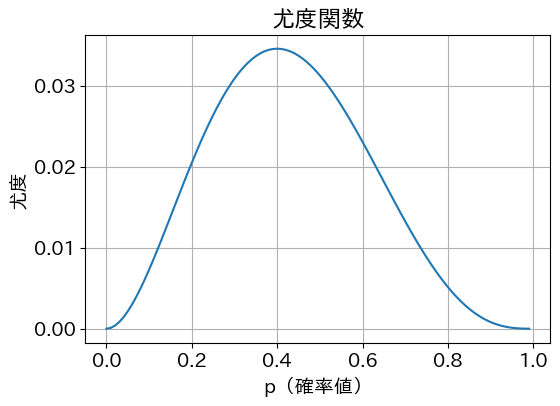

In [4]:
# 尤度関数のグラフ
def lh(p):
  return p ** 2 * (1 - p) ** 3

# グラフ描画用x座標の定義
# 0から1まで0.01刻み
p = np.arange(0, 1, 0.01)

# グラフの描画
plt.rcParams['figure.figsize'] = (6,4)
plt.plot(p, lh(p), label='尤度関数')
plt.xlabel('p（確率値）')
plt.ylabel('尤度')
plt.title('尤度関数')

- 改めて、最尤推定は尤度関数の値が最大になるパラメータpの値を求める手法
  - 上記の簡単な数式の場合、微分計算で解析的に解けるが、勾配降下法で解く。

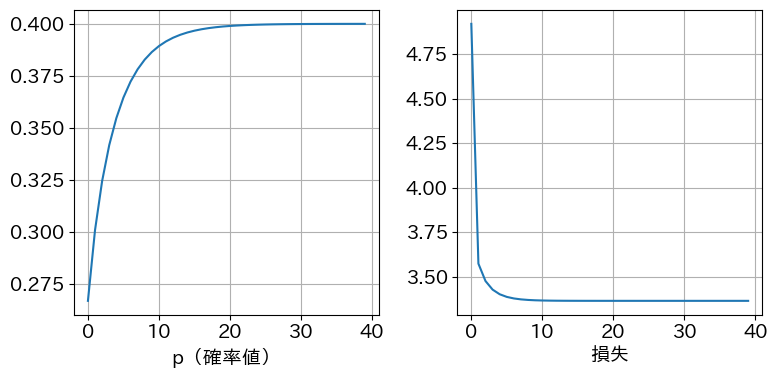

In [5]:
# 最尤推定の繰り返し計算
import torch # 確率pの最適化を行う微分計算や、勾配降下法を行うためのライブラリ

def log_lh(p): # 対数尤度関数
  return ( 2 * torch.log(p) + 3 * torch.log(1 - p) )

num_epochs = 40 # 繰り返し回数
lr = 0.01 # 学習率

# パラメータの初期値( p = 0.1 )
# requires_grad = TrueでPytorchはpの勾配を自動で追跡し、計算可能にする（勾配降下法による最適化に必須）
p  = torch.tensor(0.1, dtype = torch.float32, requires_grad=True)

#(エポック数、確率値、損失)のログを格納する変数
logs = np.zeros((0,3))

for epoch in range(num_epochs):
  loss = -log_lh(p) # 損失計算
  loss.backward() # PyTorchの自動微分機能を使い、損失関数に対する p の勾配を計算
   # 勾配は、計算グラフ上で 勾配を追跡するように設定されたテンソル（requires_grad=True）に対して計算
   # パラメータ p に対して requires_grad=True が設定されているため、loss.backward() を実行すると、p に対する勾配が計算されます。
   # その勾配は p.grad に格納
  with torch.no_grad(): # 勾配の追跡を停止し、パラメータ p を更新
    p -= lr * p.grad
    p.grad.zero_()
  log = np.array([epoch, p.item(), loss.item()]).reshape(1,-1)
  logs = np.vstack((logs, log)) # 記録したデータを logs に保存

# 上のプログラムでは尤度関数の代わりにその対数を取った対数尤度関数を用い、
# さらにそのマイナスを取った値を損失として繰り返し処理での微分計算対象としている。
# 計算の途中経過は全て変数logsに保存されています。

plt.rcParams['figure.figsize'] = (8,4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:,0], logs[:,1])
axes[0].set_xlabel('p（確率値）')
axes[1].plot(logs[:,0], logs[:,2])
axes[1].set_xlabel('損失')

plt.tight_layout()
plt.show()






- 結果として、
  - 0.4の確率値が繰り返し計算で導出されている。
- 今回の問題は、求めるパラメータがp一つだけというとてもシンプルな問題。
- 確率値 p を求める問題と、線形回帰で（w_0 , w_1）を求める問題の間には、推定するパラメータをどう決定するかという共通点があります
  - パラメータを
  $$
    y = w_0 + w_1 x
  $$
  という一次関数の傾きと定数に取り替えると、線形単回帰になる。

- 線形単回帰の問題に最尤推定を適用すると、最適なパラメータの組み（w_0 , w_1）が求まる。
  - これが通常の機械学習の裏でやっている処理

- 同じ線形回帰の問題に対してベイズ推論を適用することも可能。
  - この場合、パラメータ（w_0 , w_1）がそれぞれ、確率分布として求められることになる

In [6]:
print(np.array([epoch, p.item(), loss.item()]).reshape(1,-1))
print(np.array([epoch, p.item(), loss.item()]).reshape(3,-1))
print(np.array([epoch, p.item(), loss.item()]))

[[39.000  0.400  3.365]]
[[39.000]
 [ 0.400]
 [ 3.365]]
[39.000  0.400  3.365]


## ベイズ推論（確率モデル定義）
- 最尤推定同様に、同じ問題に対してベイズ推論で取り組んでみる

- ベイズ推論プログラミングの手順
  - 1. データ準備
    - pandas, Numpyなどで
  - 2. 確率モデル定義
    - 確率変数の関係を確率モデル化し、PyMCにより記述
  - 3. サンプリング
    - PyMCのsample関数でサンプリングデータの生成
  - 4. 結果分析
    - 主にArvizライブラリを用いて、サンプリング結果を統計的に分析


In [7]:
# データ準備
X = np.array([1, 0,  0, 1, 0])
X

array([1, 0, 0, 1, 0])

In [14]:
# 確率モデル定義　＝　PyMCで表現する

model1 = pm.Model()

with model1:
  # pm.Uniform()は一様分布を表す
  p = pm.Uniform('p', lower = 0.0, upper = 1.0)
  
  # pm.Bernoulli()はベルヌーイ分布を表す
  X_obs = pm.Bernoulli('X_obs', p=p, observed = X)

1. 確率変数間の関係性：一様分布の確率変数pが、次のベルヌーイ分布のコンストラクタに対して確率値を示す引数として渡される
   1. = 事前分布が該当
2. 観測値との関係性：事前に準備した観測値を表すXがベルヌーイ分布のコンストラクタに対してobserved引数として渡される。
   1. = 観測値が該当

- 具体的な流れ
  - 一様分布が生成する確率変数 p は、0.0～1.0の間でどの値でも等しい確率で取り得る値です。
  - ベルヌーイ分布は、その p を使って、試行（例えばコインを投げる）の成功確率として扱い、0（失敗）か1（成功）の値を生成します

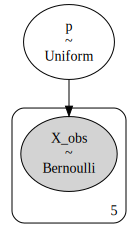

In [17]:
# 確率モデルの可視化
g = pm.model_to_graphviz(model1)
display(g)

- 図の意味
  1. 丸で示されるノードが確率分布を示す
  2. ノード内の上の表記が確率変数名、下が確率分布クラス名
  3. 矢印により確率変数間の関係性が示される
  4. 繰り返し構造は枠で囲んで示す
  5. 枠の右下の数字は繰り返し数
  6. 色がついたノードは、観測値があることを示す

## ベイズ推論（サンプリング）
- サンプリング時にデフォルト値から変更することの多い重要な3つのパラメータ
  - サンプリングはPyMCにおいて根幹的な機能（そのアルゴリズム　MCMC:Markov Chain Monte Carloは入門書の範囲外）
  - イメージ：観測値を満たすような、事前分布に従う乱数（サンプル値）を計算していく。
    - 乱数（サンプル値）は確率変数が連続分布に従う場合、1つ前の値から少し変えた値になる。
    - つまり、前の乱数（サンプル値）を受けて次の乱数（サンプル値）が定まる
  1. __chains__ パラメータ
    - サンプル値系列　という概念
    - サンプルの初期値が異なると、全く別の傾向をもったサンプル値系列ができる可能性がある。
    - __初期値を変えて複数のサンプル値系列で結果を確認する仕組み__ をsample関数は持っている。
    - そのためのパラメータchains
      - デフォルト値２で、より大きな数に変更することで得られた確率分布がたまたま特定の初期サンプル値で発生したものなのか、一般的なものかを判断できる。
  2. __tune__ パラメータ
    - sample関数内部のMCMCアルゴリズムは、うまく初期値と変更量を選ぶと、
      - __サンプル値の変化がて以上状態になる性質__　を持つ
    - つまり、サンプル値系列で見た時に、__初期状態が不安定で、徐々に結果が安定してくる傾向__ がある。
    - そのため、__不安定なことが多い初期状態のサンプル値を分析対象から外す__　ためのパラメータ
    - デフォルト値は1000

  3. __draws__ パラメータ
    - tuneと逆で、__分析対象として利用されるサンプル数__　を示す。
    - 同じくデフォルト値は1000
    - 複雑な構成の確率モデルの場合、 __予測結果をより確実なものとするため、この値をデフォルトより大きくすることが一般的__

  まとめ. 分析可能なサンプル数は、Numpyのshapeで表すと、(chains, draws) 個


  補足パラメータ. 
    - __target_accept__ パラメータ
      - ベイズ推論の収束が不十分な場合に利用するチューニングパラメータという理解でひとまずOK
    - __init__ パラメータ
      - サンプリングするパラメータの初期値を決定するアルゴリズムに関するパラメータ
    - __step__ パラメータ
      - 1つ前のサンプリング値から次のサンプリング値を計算するためのアルゴリズム
    
    - init,stepのパラメータも高度の数学的知識が必要。。
      - 最初の段階ではチューニングして使う必要はなくデフォルト値で十分。（本書では存在の認知だけでOK）
    



In [18]:
# パラメータ値を明示的に設定してサンプリング
with model1:
  idata1_1 = pm.sample(
    # 乱数系列の数（デフォルト）
    chains = 3,
    # 捨てるサンプル数
    tune = 2000,
    # 取得するサンプル数
    draws = 2000,
    random_seed = 42
  )

# 各chainで2000＋2000の4000サンプルが得られる
# 分析に使われるのは2000サンプル

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
# デフォルト値でサンプリング
with model1:
  idata1_2 = pm.sample(
    random_seed = 42
  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## ベイズ推論（結果分析）
- 因果関係では
  1. 一様分布から確率変数pが出力
  2. そのpを引数にベルヌーイ分布が定まる
  3. 最後にベルヌーイ分布に従う確率変数として観測値が得られる

- 実際のベイズ推論では、逆
  1. 観測値
  2. ベルヌーイ分布を経由
  3. 元々一様分布だった確率変数pの事後分布がサンプル値の配列として得られる
    - このサンプル値に処理を行い、事後分布の性質を確認する。
    - いわば、本来の因果関係の逆方向で事後分布を推論する＝　__ここがベイズ推論の本質__


```text
  結果分析で実施すること
  1. サンプリングが正常にできていること
  2. 可視化による確率分布の確認
  3. 統計分析による確率分布の確認
  上記でよく使われる関数を以下で説明する
```

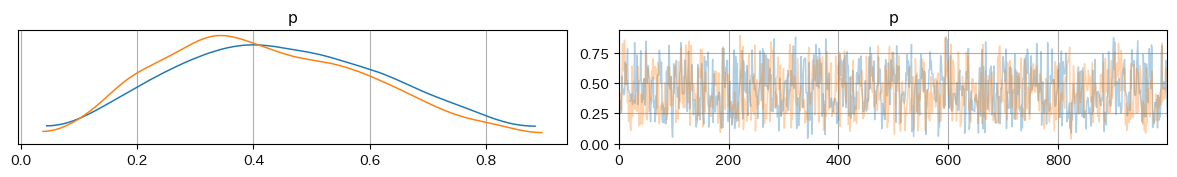

In [24]:
# plot_trace()でサンプリング結果を可視化
# サンプリングが正常にできていることの確認で利用する

az.plot_trace(idata1_2, compact = False) # compact = Falseで複数のサンプル値系列の色分け
plt.tight_layout() # グラフの重なりを解消

- 左のグラフ
  - 確率変数の値と発生頻度
  - ※ 分析対象の確率変数が連続分布のとき、一旦ヒストグラムを作ってそれを連続的な関数で近似している。（確率密度関数に該当）
    - 確率密度関数においては、相対的な値に意味があり、絶対的な値はあまり意味を持たない。（左図の縦軸にスケールがない理由）
      ```text
      相対的な値に意味があり、絶対的な値はあまり意味を持たない。　
      　＝　あくまで見れるのは他の場所と比べてどこにデータが集中しているかという話だから

      確率は区間に対して定義され、その区間内の確率は、確率密度関数の下にある面積として計算されます（積分によって）。
      したがって、確率密度が大きい場所ほど「その範囲にデータが集中している」という相対的な意味を持ちますが、確率密度自体の絶対値が「確率」ではないのです。
      ```
    - このグラフで2つのグラフ形が近かったらベイズ推論のアルゴリズムが正しく動いていることを意味する。極端に異なるなら不具合。
- 右のグラフ
  - 横軸が繰り返し数、縦軸が分析対象の確率変数の値として値の変化を見ている。
  - 確率変数の値の軸が左のグラフでは横軸、右のグラフでは縦軸
    - 縦軸の値が一定範囲を何度も行き来している状態が正しい行動

Text(0.5, 1.0, 'ベイズ推論結果 初期版')

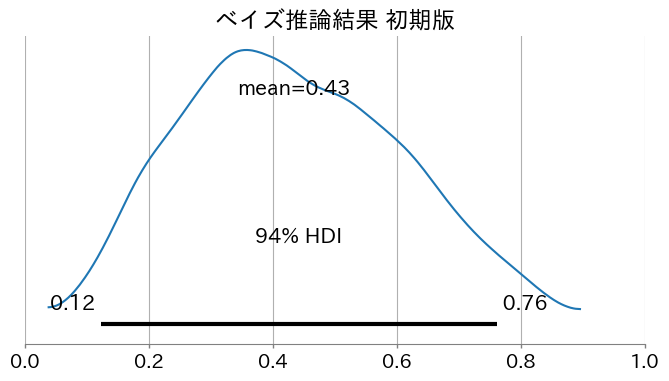

In [25]:
# plot_posterior()で確率分布を可視化
ax = az.plot_posterior(idata1_2)
ax.set_xlim(0, 1) # x軸の範囲を0から1に限定
ax.set_title('ベイズ推論結果 初期版') # タイトルの設定

- 上記グラフで見れるバー　＝　94%HDIの範囲
  - ここが最終的に利用される
  - hdi_probオプションパラメータで変更可能

In [26]:
# summary()で統計量を表示
summary1_2 = az.summary(idata1_2)
display(summary1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.434,0.177,0.123,0.761,0.006,0.004,873.000,1315.000,1.000


- mcse_mean以降の各項目はベイズ推論のアルゴリズムが正しく機能しているかの指標
- 目安
  - mcse_mean: 0.01以下
  - ess_bulk: 400以上
  - r_hat: 1.01以下

- 略称
  - mcseはモンテカルロ標準エラーの略称
  - essは有効サンプルサイズの略称

### ここまでのまとめ
1. 情報がわかる前の状態（事前分布）
    - 事前分布として、一様分布を仮定しています。この一様分布は、確率 𝑝（例えば、コインが表を出す確率）が0から1の間で等しい確率であり得ると考える、つまり事前に特定の情報や偏りがない状態を示します。

2. 情報が入ってくる（観測データ）
    - 次に、実際の観測データ（例えば、コインを10回投げて4回表が出たという結果）を使います。このデータが「情報が入ってきた状態」に該当
    - この観測データに対して、ベルヌーイ分布を仮定します。ベルヌーイ分布は、1回の試行で成功（表が出る）の確率 𝑝に基づいて結果（0か1、表か裏）を出す分布
    - 観測データ 𝑋は 𝑝に従うベルヌーイ分布に従うと仮定

3. 事後分布を推定する（ベイズ推論）
    - ベイズ推論では、事前分布（一様分布）と観測データ（ベルヌーイ分布に従う結果）を組み合わせて、確率𝑝の事後分布を計算します
    - 「幅で推定する」とは、観測データから最もありそうな 𝑝の範囲（確率分布）を推定することです。この「幅」が事後分布の形を示し、𝑝がどの範囲に収まるかを表します。

4. サンプリング
    - 求めた事後分布からサンプリングを複数回数行って、事後分布の形を捉える

### ベイズ推論（二項分布バージョン）
- [1,0,0,1,0]と観測値を5つの個別の要素に分けたため、ベルヌーイ分布を定義していた。
- 本質的に必要な情報は、「5回中2回当たり」の部分。
  - 何度目で当たりが出たとかの情報はなくても確率pの予測はできるはずなので __二項分布__ になります。

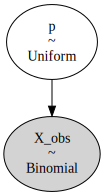

In [28]:
# コンテキスト定義
model2 = pm.Model()

with model2:
  # pm.Uniform()は一様分布を表す
  p = pm.Uniform('p', lower = 0.0, upper = 1.0)
  
  # pm.Binomial()は二項分布を表す
  # p:成功確率
  # n:試行回数
  X_obs = pm.Binomial('X_obs', p=p, n = 5, observed = X.sum())

g = pm.model_to_graphviz(model2)
display(g)


- ベルヌーイ分布と異なり、繰り返し表記が無くなってる

In [30]:
with model2:
  idata2_1 = pm.sample(
    # # 乱数系列の数（デフォルト）
    # chains = 3,
    # # 捨てるサンプル数
    # tune = 2000,
    # # 取得するサンプル数
    # draws = 2000,
    random_seed = 42
  )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'ベイズ推論結果 二項分布版')

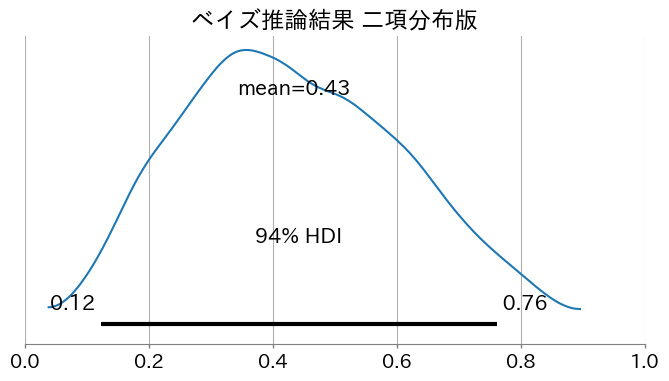

In [31]:
# plot_posterior()で確率分布を可視化
ax = az.plot_posterior(idata2_1)
ax.set_xlim(0, 1) # x軸の範囲を0から1に限定
ax.set_title('ベイズ推論結果 二項分布版') # タイトルの設定

## ベイズ推論（試行回数を増やす）
- 二項分布のまま、試行回数を変える

In [32]:
# コンテキスト定義
model3 = pm.Model()

with model3:
  # pm.Uniform()は一様分布を表す
  p = pm.Uniform('p', lower = 0.0, upper = 1.0)
  
  # pm.Binomial()は二項分布を表す
  # p:成功確率
  # n:試行回数
  X_obs = pm.Binomial('X_obs', p=p, n = 50, observed = 20)

In [33]:
with model3:
  idata3_1 = pm.sample(
    # # 乱数系列の数（デフォルト）
    # chains = 3,
    # # 捨てるサンプル数
    # tune = 2000,
    # # 取得するサンプル数
    # draws = 2000,
    random_seed = 42
  )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'ベイズ推論結果 二項分布版')

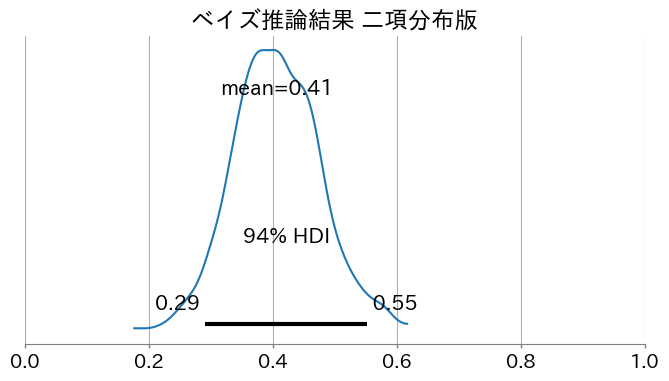

In [34]:
# plot_posterior()で確率分布を可視化
ax = az.plot_posterior(idata3_1)
ax.set_xlim(0, 1) # x軸の範囲を0から1に限定
ax.set_title('ベイズ推論結果 二項分布版') # タイトルの設定

### ベイズ推論（事後分布の変更）

In [44]:
# コンテキスト
model4 = pm.Model()

with model4:
  # 一様分布
  p = pm.Uniform('p', lower = 0.1, upper = 0.9)
  
  # 5回中2回成功
  X_obs = pm.Binomial('X_obs', p=p, n = 5, observed = 2)
  
  idata4 = pm.sample(random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 1.0, 'ベイズ推論結果 二項分布版')

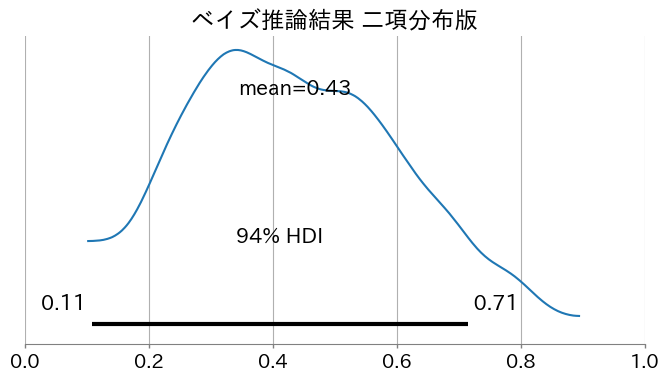

In [45]:
# plot_posterior()で確率分布を可視化
ax = az.plot_posterior(idata4)
ax.set_xlim(0, 1) # x軸の範囲を0から1に限定
ax.set_title('ベイズ推論結果 二項分布版') # タイトルの設定

In [46]:
# summary()で統計量を表示
summary = az.summary(idata4)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.435,0.169,0.108,0.714,0.006,0.004,719.000,669.000,1.000


### ベータ分布で直接確率分布を求める

- 今回、ベイズ推論の対象にしている確率モデルは、確率分布としては第二章で説明したベータ分布になることが、数学的に証明
- このことを、試行回数を増やした前述の確率分布のグラフと対応するべーた分布のグラフの重ね書きで確認する


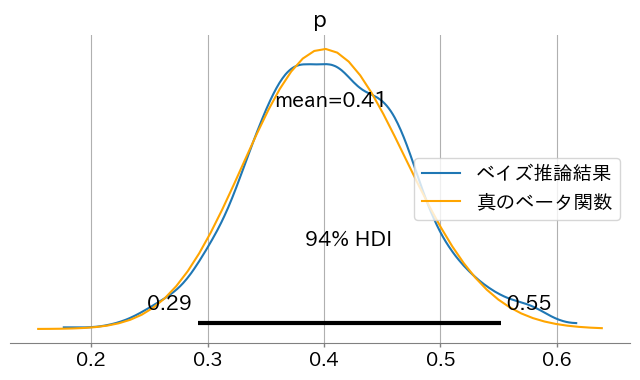

In [47]:
# 真のベータ関数
from scipy import stats
alpha = 20 + 1
beta = 30 + 1

true_beta = stats.beta(alpha, beta)

# ベイズ推論結果の可視化
# idata3は前述のものを利用
ax = az.plot_posterior(idata3_1)
ax.lines[0].set_label('ベイズ推論結果')

# 真のベータ関数の描画
x = np.linspace(*ax.get_xlim())
ax.plot(x, true_beta.pdf(x), label='真のベータ関数', color='orange')
ax.legend(loc = 'center right')